## __Ocean salinity investigation:__

### __Hands-on tutorial of AWS in-region access of NASA Earthdata products__

This notebook provides a basic workflow to interact with data "in-place" from the NASA Earthdata Cloud, by accessing AWS s3 locations provided by NASA Harmony outputs without the need to download data. *More info on benefits and differences between this workflow and "traditional" download workflows...*. 

#### Learning objectives:
- 
- 
- 


#### __First, some background on our different AWS access methods...__

- Harmony: Need access keys
- CMR direct access: (maybe not showing this in this notebook),
- MUR data in AWS OpenRegistry

#### __Set up for in-region access__

__This notebook must be running within an AWS EC2 instance running in the `us-west-2` region.__

For the live AGU Workshop, our BinderHub instance already takes care of steps 1 and 2, but these instructions are provided so that you can set this up in your own AWS account outside of the workshop.

1. Follow tutorials 01 through 03 of the [NASA Earthdata Cloud Primer](https://earthdata.nasa.gov/learn/user-resources/webinars-and-tutorials/cloud-primer) to set up an EC2 instance within us-west-2. Ensure you are also following step 3 in the ["Jupyter Notebooks on AWS EC2 in 12 (mostly easy) steps"](https://medium.com/@alexjsanchez/python-3-notebooks-on-aws-ec2-in-15-mostly-easy-steps-2ec5e662c6c6) article to set the correct security group settings needed to connect your local port to your EC2’s notebook port thru SSH.

2. Follow the remaining instructions in the Medium article above up until Step 11 (running Jupyter Lab). These instructions include installation of Anaconda3 (including Jupyter Lab) in your ec2 instance. Note the following updates and suggestions:
    * Step 5: Type the following command instead of what is suggested in the article: `ssh -i "tutorialexample.pem" ec2-user@ec2-54-144-47-199.compute-1.amazonaws.com -L 9999:localhost:8888`. This will eliminate the need to create a ssh config file in your home directory (Step 10).
    * As of December 2020, the most current Anaconda3 Linux distribution is: https://repo.anaconda.com/archive/Anaconda3-2020.11-Linux-x86_64.sh
    * The Anaconda installation prompts are not the same as in the article. You will not be prompted to include Anaconda3 in your .bashrc PATH so you can skip to their step 9. Instead select "yes" to initialize Anaconda by running `conda init`. 

Before moving over to Jupyter Lab, set up your Earthdata Login authentication and Harmony access keys:

3. Setup your `~/.netrc` for Earthdata Login in your ec2 instance:

```
cd ~
touch .netrc
echo "machine urs.earthdata.nasa.gov login uid_goes_here password password_goes_here" > .netrc
chmod 0600 .netrc
```

4. Run the following in your ec2 instance terminal window to generate short-term Harmony access keys:

`curl -Ln -bj https://harmony.earthdata.nasa.gov/cloud-access.sh`

5. Set your environment variables based on the keys provided in step 4:

`export AWS_ACCESS_KEY_ID='...
export AWS_SECRET_ACCESS_KEY='...'
export AWS_SESSION_TOKEN='...'
export AWS_DEFAULT_REGION='us-west-2'`

Note that these expire within 8 hours of the script generation.

6. Launch jupyter lab:

`jupyter lab --no-browser`

Copy the URL that begins with `http://localhost:8888` into a browser window. Replace `8888` with `9999`. 

Once the notebook is running in Jupyter Lab, run the following cell to install Python dependencies, import necessary modules, and set notebook defaults:

In [5]:
import tutorial_helper_functions as fn
import sys
!{sys.executable} -m pip install intake-stac s3fs rasterio # Only need to run these the first time after your ec2 instance is set up, if running within your own AWS account following the instructions above
from pprint import pprint
import intake
import s3fs
import rasterio
import zarr
import matplotlib.pyplot as plt
%matplotlib inline

### __Earthdata Login__

In [10]:
# Get your authentication token for searching restricted records in the CMR:
_token = fn.setup_cmr_token_auth(endpoint="cmr.earthdata.nasa.gov")

# Start authenticated session with URS to allow restricted data downloads:
fn.setup_earthdata_login_auth(endpoint="urs.earthdata.nasa.gov")

Username:  amy.steiker
Password:  ·········


### __CMR Search/Discovery__

In [3]:
# search_parameters = { 
#     'smap': {'short_name': 'SMAP_RSS_L3_SSS_SMI_8DAY-RUNNINGMEAN_V4','version': '4.0', 'provider': 'POCLOUD','bounding_box': bounding_box,'temporal': temporal},
#     'modis': {'short_name': 'MODIS_T-JPL-L2P-v2019.0','version': '2019.0','provider': 'POCLOUD','bounding_box': bounding_box,'temporal': temporal},
#     'mur': {'short_name': 'xx','version': 'xx','provider': 'xx','bounding_box': bounding_box,'temporal': temporal},
#             }


### __SMAP Sea Surface Salinity__

Zarr reformatting

In [4]:
smap_collection_id='C1940468263-POCLOUD'
harmony_root = 'https://harmony.earthdata.nasa.gov'
params = {
    'collection_id': smap_collection_id,
    'ogc-api-coverages_version': '1.0.0',
    'variable': 'all',
    'format': 'application/x-zarr',
    'start': '2020-11-15T00:00:00.000Z',
    'stop':'2020-11-15T23:59:59.000Z'
}

smap_url = harmony_root+'/{collection_id}/ogc-api-coverages/{ogc-api-coverages_version}/collections/{variable}/coverage/rangeset?format={format}&subset=time("{start}":"{stop}")'.format(**params)

In [5]:
smap_results = fn.get_harmony_results(smap_url, _token)

Request URL https://harmony.earthdata.nasa.gov/C1940468263-POCLOUD/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?format=application/x-zarr&subset=time("2020-11-15T00:00:00.000Z":"2020-11-15T23:59:59.000Z")
Job URL https://harmony.earthdata.nasa.gov/jobs/5f372659-d16f-4d8f-a476-9a1029bb9d5f
Job status is running. Progress is  0 %. Trying again.
Job status is running. Progress is  0 %. Trying again.
Job status is running. Progress is  16 %. Trying again.
Job status is running. Progress is  50 %. Trying again.
Job status is running. Progress is  66 %. Trying again.
Job status is running. Progress is  83 %. Trying again.
Job progress is 100%.


In [6]:
pprint(smap_results)

{'createdAt': '2020-11-29T21:42:28.650Z',
 'jobID': '5f372659-d16f-4d8f-a476-9a1029bb9d5f',
 'links': [{'href': 'https://harmony.earthdata.nasa.gov/jobs/5f372659-d16f-4d8f-a476-9a1029bb9d5f',
            'rel': 'self',
            'title': 'Job Status',
            'type': 'application/json'},
           {'href': 'https://harmony.earthdata.nasa.gov/stac/5f372659-d16f-4d8f-a476-9a1029bb9d5f/',
            'rel': 'stac-catalog-json',
            'title': 'STAC catalog',
            'type': 'application/json'},
           {'href': 'https://harmony.earthdata.nasa.gov/cloud-access.sh',
            'rel': 'cloud-access-sh',
            'title': 'Access keys for s3:// URLs, usable from AWS us-west-2 '
                     '(Shell format)',
            'type': 'application/x-sh'},
           {'href': 'https://harmony.earthdata.nasa.gov/cloud-access',
            'rel': 'cloud-access-json',
            'title': 'Access keys for s3:// URLs, usable from AWS us-west-2 '
                     '(JSON

#### __Explore the STAC response using `intake-stac`__

Each asynchronous request response includes a [STAC](https://stacspec.org/) catalog that contains spatial and temporal metadata for each output, or STAC item. These metadata fields now reflect the values of the subsetted outputs themselves, providing transformation metadata for users. The [Pangeo gallery](http://gallery.pangeo.io/repos/pangeo-data/pangeo-tutorial-gallery/intake.html) includes great guidance on how to work with stac catalogs to access cloud-hosted data in place.

In [7]:
job = smap_results['jobID']
print(job)

stac_root = 'https://harmony.earthdata.nasa.gov/stac/{jobID}/{item}'

5f372659-d16f-4d8f-a476-9a1029bb9d5f


__Open STAC Catalog from Harmony response__

Several STAC items are listed, corresponding to each Zarr output.

In [8]:
stac_cat = intake.open_stac_catalog(stac_root.format(jobID=job,item=''),name='Harmony output')
display(list(stac_cat))

['5f372659-d16f-4d8f-a476-9a1029bb9d5f_0',
 '5f372659-d16f-4d8f-a476-9a1029bb9d5f_1',
 '5f372659-d16f-4d8f-a476-9a1029bb9d5f_2',
 '5f372659-d16f-4d8f-a476-9a1029bb9d5f_3',
 '5f372659-d16f-4d8f-a476-9a1029bb9d5f_4',
 '5f372659-d16f-4d8f-a476-9a1029bb9d5f_5']

We can inspect the metadata of each STAC item, which includes the bounding box, coordinates, and start and end time. We'll focus on the first output:

In [9]:
item_0 = f'{job}_0'
item = stac_cat[item_0]
print(type(item))
print(item.metadata)

<class 'intake_stac.catalog.StacItem'>
{'created': '2020-11-29T21:42:28.650Z', 'license': 'various', 'start_datetime': '2020-11-07T12:00:00.000Z', 'end_datetime': '2020-11-15T12:00:00.000Z', 'datetime': datetime.datetime(2020, 11, 7, 12, 0, tzinfo=tzlocal()), 'bbox': [0.125, -89.875, -0.125, 89.875], 'geometry': {'type': 'MultiPolygon', 'coordinates': [[[-180, -89.875], [-180, 89.875], [-0.125, 89.875], [-0.125, -89.875], [-180, -89.875]], [[0.125, -89.875], [0.125, 89.875], [180, 89.875], [180, -89.875], [0.125, -89.875]]]}, 'date': datetime.date(2020, 11, 7), 'catalog_dir': ''}


Each item can be accessed from the harmony s3 staging bucket:

In [10]:
assets = list(item)
asset = item[assets[0]]
print(type(asset))
print(asset.urlpath)

<class 'intake_xarray.raster.RasterIOSource'>
s3://harmony-prod-staging/public/harmony/netcdf-to-zarr/fd3b035e-69a3-484b-8dea-2e9b6012906e/RSS_smap_SSS_L3_8day_running_2020_316_FNL_v04.0.zarr


### __Access Harmony outputs directly from STAC__

The Harmony output image is loaded up into an xarray data array directly from the STAC catalog.

In [11]:
smap_da = asset.to_dask()

RasterioIOError: '/vsis3/harmony-prod-staging/public/harmony/netcdf-to-zarr/fd3b035e-69a3-484b-8dea-2e9b6012906e/RSS_smap_SSS_L3_8day_running_2020_316_FNL_v04.0.zarr' not recognized as a supported file format.

In [ ]:
#smap_da.plot.imshow()

## Related RasterIO bug??? https://rasterio.groups.io/g/main/topic/31734579 

Trying outside of STAC instead using Tutorial 8...

In [12]:
link = asset.urlpath

In [13]:
fs = s3fs.S3FileSystem(client_kwargs={'region_name':'us-west-2'})
store = fs.get_mapper(root=link, check=False)

zarr_file = zarr.open(store)

In [14]:
print(zarr_file.tree())
print(zarr_file.sss_smap.info)

/
 ├── fland (720, 1440) float32
 ├── gice (720, 1440) float32
 ├── gland (720, 1440) float32
 ├── lat (720,) float32
 ├── lon (1440,) float32
 ├── nobs (720, 1440) int32
 ├── nobs_40km (720, 1440) int32
 ├── sss_ref (720, 1440) float32
 ├── sss_smap (720, 1440) float32
 ├── sss_smap_40km (720, 1440) float32
 ├── sss_smap_uncertainty (720, 1440) float32
 ├── surtep (720, 1440) float32
 └── time (1,) float64
Name               : /sss_smap
Type               : zarr.core.Array
Data type          : float32
Shape              : (720, 1440)
Chunk shape        : (720, 1440)
Order              : C
Read-only          : False
Compressor         : Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)
Store type         : fsspec.mapping.FSMap
No. bytes          : 4147200 (4.0M)
Chunks initialized : 1/1



(-0.5, 719.5)

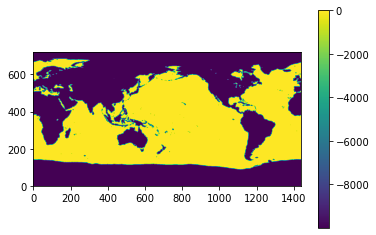

In [15]:
plt.imshow(zarr_file['gice']);
plt.colorbar()

#flip the image
ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])


### (Optional) Import the zarr into xarray and plot

In [16]:
import xarray as xr
ds_zarr = xr.open_zarr(store)
print(ds_zarr['sss_smap'])

<xarray.DataArray 'sss_smap' (lat: 720, lon: 1440)>
dask.array<zarr, shape=(720, 1440), dtype=float32, chunksize=(720, 1440), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -89.875 -89.625 -89.375 ... 89.375 89.625 89.875
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.375 359.625 359.875
Attributes:
    long_name:      SMAP sea surface salinity smoothed to approx 70km resolution
    standard_name:  sea_surface_salinity
    units:          1e-3
    valid_max:      45.0
    valid_min:      0.0


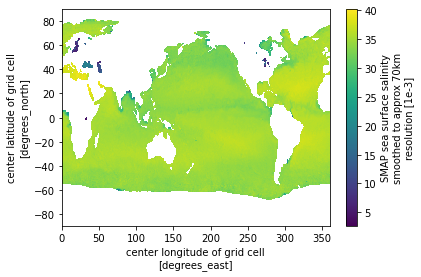

In [17]:
ds_zarr['sss_smap'].where(ds_zarr['sss_smap'] > 0).plot()

### __MODIS SST__

#### __On your own activity since this mimics same SMAP workflow?? Maybe have them explore using CMR or EDSC to find concurrent data first using previous tutorials...__

Spatial subsetting

In [8]:
modis_collection_id='C1940475563-POCLOUD'
harmony_root = 'https://harmony.earthdata.nasa.gov'
params = {
    'collection_id': modis_collection_id,
    'ogc-api-coverages_version': '1.0.0',
    'variable': 'all',
    'lat':'(-1.31873:2.96977)',
    'lon':'(-53.00754:-46.39751)',
    'start': '2020-11-15T00:00:00.000Z',
    'stop':'2020-11-15T23:59:59.000Z'
}

modis_url = harmony_root+'/{collection_id}/ogc-api-coverages/{ogc-api-coverages_version}/collections/{variable}/coverage/rangeset?&subset=lat{lat}&subset=lon{lon}&subset=time("{start}":"{stop}")'.format(**params)

In [11]:
modis_results = fn.get_harmony_results(modis_url, _token)

Request URL https://harmony.earthdata.nasa.gov/C1940475563-POCLOUD/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?&subset=lat(-1.31873:2.96977)&subset=lon(-53.00754:-46.39751)&subset=time("2020-11-15T00:00:00.000Z":"2020-11-15T23:59:59.000Z")
Job URL https://harmony.earthdata.nasa.gov/jobs/77a05b82-d655-485d-b1c5-8269af34b461
Job status is running. Progress is  0 %. Trying again.
Job status is running. Progress is  0 %. Trying again.
Job status is running. Progress is  40 %. Trying again.
Job status is running. Progress is  80 %. Trying again.
Job progress is 100%.


In [12]:
pprint(modis_results)

{'createdAt': '2020-11-29T22:03:56.691Z',
 'jobID': '77a05b82-d655-485d-b1c5-8269af34b461',
 'links': [{'href': 'https://harmony.earthdata.nasa.gov/jobs/77a05b82-d655-485d-b1c5-8269af34b461',
            'rel': 'self',
            'title': 'Job Status',
            'type': 'application/json'},
           {'href': 'https://harmony.earthdata.nasa.gov/stac/77a05b82-d655-485d-b1c5-8269af34b461/',
            'rel': 'stac-catalog-json',
            'title': 'STAC catalog',
            'type': 'application/json'},
           {'bbox': [-47.2, -0.6, -46.4, 3],
            'href': 'https://harmony.earthdata.nasa.gov/service-results/harmony-prod-staging/public/podaac/l2-subsetter/54524d0b-a8a4-4996-ab9c-02da093c3610/20201115005001-JPL-L2P_GHRSST-SSTskin-MODIS_T-N-v02.0-fv01.0_subsetted.nc',
            'rel': 'data',
            'temporal': {'end': '2020-11-15T00:54:59.000Z',
                         'start': '2020-11-15T00:50:01.000Z'},
            'title': 'G1968275752-POCLOUD',
            't

Open VIA STAC...

In [13]:
job = modis_results['jobID']
print(job)

stac_root = 'https://harmony.earthdata.nasa.gov/stac/{jobID}/{item}'

77a05b82-d655-485d-b1c5-8269af34b461


__Open STAC Catalog from Harmony response__

Several STAC items are listed, corresponding to each Zarr output.

In [14]:
stac_cat = intake.open_stac_catalog(stac_root.format(jobID=job,item=''),name='Harmony output')
display(list(stac_cat))

['77a05b82-d655-485d-b1c5-8269af34b461_0',
 '77a05b82-d655-485d-b1c5-8269af34b461_1',
 '77a05b82-d655-485d-b1c5-8269af34b461_2',
 '77a05b82-d655-485d-b1c5-8269af34b461_3',
 '77a05b82-d655-485d-b1c5-8269af34b461_4']

We can inspect the metadata of each STAC item, which includes the bounding box, coordinates, and start and end time. We'll focus on the first output:

In [15]:
item_0 = f'{job}_0'
item = stac_cat[item_0]
print(type(item))
print(item.metadata)

<class 'intake_stac.catalog.StacItem'>
{'created': '2020-11-29T22:03:56.691Z', 'license': 'various', 'start_datetime': '2020-11-15T00:50:01.000Z', 'end_datetime': '2020-11-15T00:54:59.000Z', 'datetime': datetime.datetime(2020, 11, 15, 0, 50, 1, tzinfo=tzlocal()), 'bbox': [-47.2, -0.6, -46.4, 3], 'geometry': {'type': 'Polygon', 'coordinates': [[[-47.2, -0.6], [-47.2, 3], [-46.4, 3], [-46.4, -0.6], [-47.2, -0.6]]]}, 'date': datetime.date(2020, 11, 15), 'catalog_dir': ''}


Each item can be accessed from the harmony s3 staging bucket:

In [16]:
assets = list(item)
asset = item[assets[0]]
print(type(asset))
print(asset.urlpath)

<class 'intake_xarray.netcdf.NetCDFSource'>
s3://harmony-prod-staging/public/podaac/l2-subsetter/54524d0b-a8a4-4996-ab9c-02da093c3610/20201115005001-JPL-L2P_GHRSST-SSTskin-MODIS_T-N-v02.0-fv01.0_subsetted.nc


### __Access Harmony outputs directly from STAC__

The Harmony output image is loaded up into an xarray data array directly from the STAC catalog.

In [17]:
modis_da = asset.to_dask()

ValueError: open_local can only be used on a filesystem which has attribute local_file=True

### I dont know how to get around this error...

In [ ]:
#modis_da.plot.imshow()

### __MUR SST__

Already reformatted to Zarr in AWS Open Registry

Adapted from https://github.com/pangeo-gallery/osm2020tutorial

In [18]:
# $ conda install -c conda-forge zarr
!{sys.executable} -m pip install zarr
!{sys.executable} -m pip install aiohttp

import warnings
import numpy as np
import pandas as pd
import xarray as xr
import fsspec
import requests

In [19]:
ds_sst = xr.open_zarr('https://mur-sst.s3.us-west-2.amazonaws.com/zarr-v1',consolidated=True)

ds_sst

,Array,Chunk
Bytes,16.70 TB,129.53 MB
Shape,"(6443, 17999, 36000)","(5, 1799, 3600)"
Count,141791 Tasks,141790 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,16.70 TB,129.53 MB
Shape,"(6443, 17999, 36000)","(5, 1799, 3600)"
Count,141791 Tasks,141790 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


#### Explore data

In [20]:
sst = ds_sst['analysed_sst']

cond = (ds_sst.mask==1) & ((ds_sst.sea_ice_fraction<.15) | np.isnan(ds_sst.sea_ice_fraction))
sst_masked = ds_sst['analysed_sst'].where(cond)

### Memory issue...

In [21]:
%%time
sst_day = sst_masked.sel(time='2015-10-01',lat=slice(20,65),lon=slice(-170,-110)).load()

MemoryError: Unable to allocate 124. MiB for an array with shape (5, 1799, 3600) and data type float32

In [ ]:
# sst_day.plot()
sst_masked.plot()

### __Data Harmonization__

- analyze across data sets?
- Plot together?

### __Time Series across a large data set__

Climatology or some large data request to show power of cloud??

Stage in public s3 for this?? Or grab from Cumulus staging bucket?